In [ ]:
# Reference -  https://ucanalytics.com/blogs/forecasting-time-series-analysis-manufacturing-case-study-example-part-1/
# https://ucanalytics.com/blogs/wp-content/uploads/2017/08/ARIMA-TimeSeries-Analysis-of-Tractor-Sales.html

In [3]:

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib import rcParams
from statsmodels.tsa.seasonal import  STL
import matplotlib.pyplot as plt
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

%matplotlib inline
rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 2.5
plt.style.use('bmh')


# Visualize Tractor Sales data as time series

In [4]:
sales_data = pd.read_csv('data/tractor-sales.csv')

sales_data.head()

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203


In [ ]:
sales_data.info()

In [5]:
# since the complete date was not mentioned, we assume that it was the first of every month
dates = pd.date_range(start='2003-01-01', freq='MS', periods=len(sales_data))

In [6]:
import calendar
sales_data['Month'] = dates.month
sales_data['Month'] = sales_data['Month'].apply(lambda x: calendar.month_abbr[x])
sales_data['Year'] = dates.year

In [7]:
sales_data.drop(['Month-Year'], axis=1, inplace=True)
sales_data.rename(columns={'Number of Tractor Sold':'Tractor-Sales'}, inplace=True)


In [8]:
# set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
sales_data.set_index(dates, inplace=True)

In [9]:
# check out first 5 samples of the data
sales_data.head(5)

,Tractor-Sales,Month,Year
2003-01-01,141,Jan,2003
2003-02-01,157,Feb,2003
2003-03-01,185,Mar,2003
2003-04-01,199,Apr,2003
2003-05-01,203,May,2003


Text(0, 0.5, 'Tractor Sales')

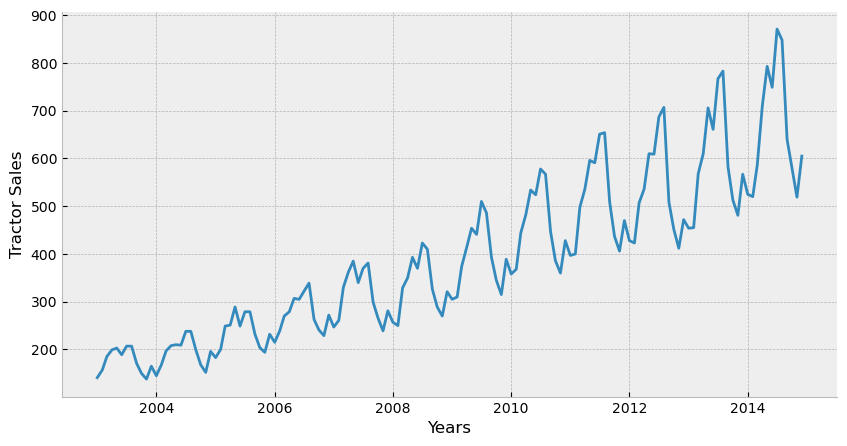

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(sales_data['Tractor-Sales'])
plt.xlabel('Years')
plt.ylabel('Tractor Sales')

In [13]:
monthly_sales_data = pd.pivot_table(sales_data, values = "Tractor-Sales", columns = "Year", index = "Month")
monthly_sales_data = monthly_sales_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales_data

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Month,,,,,,,,,,,,
Jan,141.0,145.0,183.0,215.0,247.0,257.0,305.0,358.0,397.0,428.0,454.0,525.0
Feb,157.0,168.0,200.0,239.0,261.0,250.0,310.0,368.0,400.0,423.0,455.0,520.0
Mar,185.0,197.0,249.0,270.0,330.0,329.0,374.0,444.0,498.0,507.0,568.0,587.0
Apr,199.0,208.0,251.0,279.0,362.0,350.0,414.0,482.0,536.0,536.0,610.0,710.0
May,203.0,210.0,289.0,307.0,385.0,393.0,454.0,534.0,596.0,610.0,706.0,793.0
Jun,189.0,209.0,249.0,305.0,340.0,370.0,441.0,524.0,591.0,609.0,661.0,749.0
Jul,207.0,238.0,279.0,322.0,370.0,423.0,510.0,578.0,651.0,687.0,767.0,871.0
Aug,207.0,238.0,279.0,339.0,381.0,410.0,486.0,567.0,654.0,707.0,783.0,848.0
Sep,171.0,199.0,232.0,263.0,299.0,326.0,393.0,447.0,509.0,509.0,583.0,640.0


<Axes: xlabel='Month'>

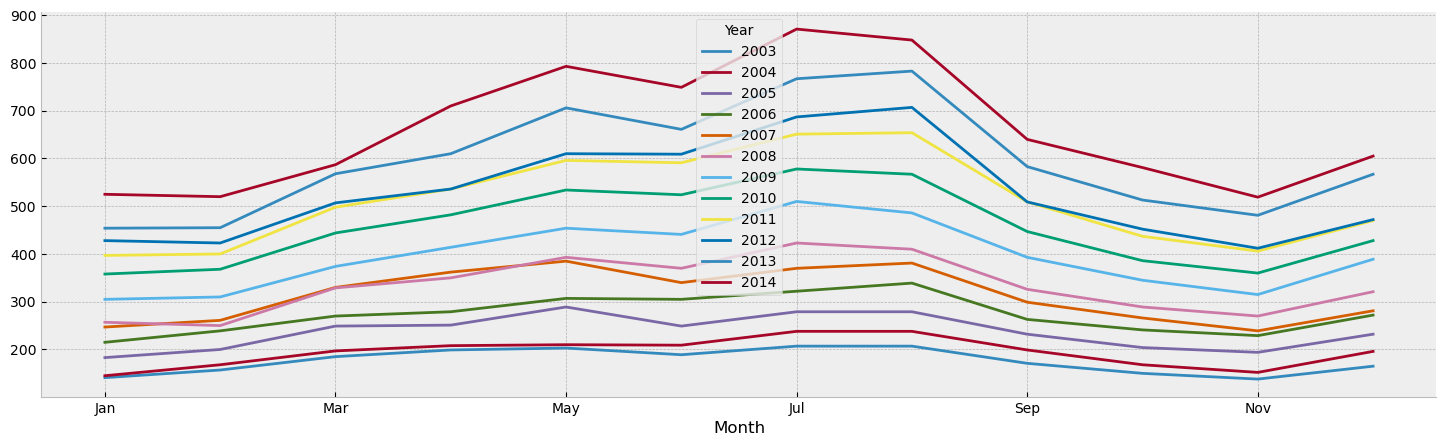

In [14]:
monthly_sales_data.plot()


In [18]:
df = sales_data[['Tractor-Sales']]

In [19]:
df

,Tractor-Sales
2003-01-01,141
2003-02-01,157
2003-03-01,185
2003-04-01,199
2003-05-01,203
...,...
2014-08-01,848
2014-09-01,640
2014-10-01,581
2014-11-01,519


## Trend - Time Series Decomposition

### Rolling Statistics - Plot Moving Average and Moving Variance

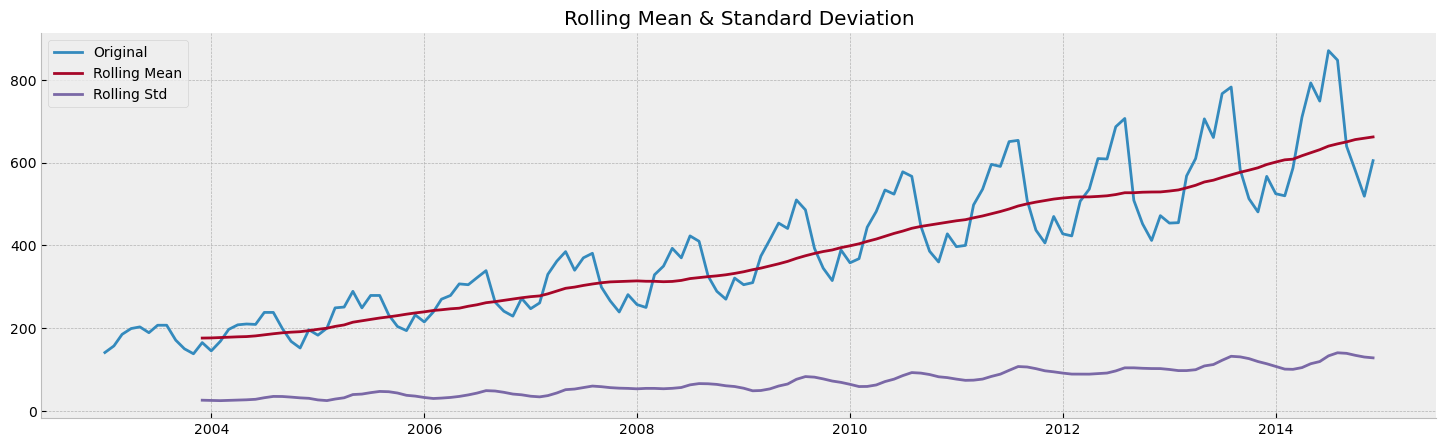

In [21]:
#Determing rolling statistics
rolmean = df.rolling(window=12).mean()
rolstd = df.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(df, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

## Seasonality – Time Series Decomposition



In [22]:
decomposition = sm.tsa.seasonal_decompose(df, model='multiplicative')


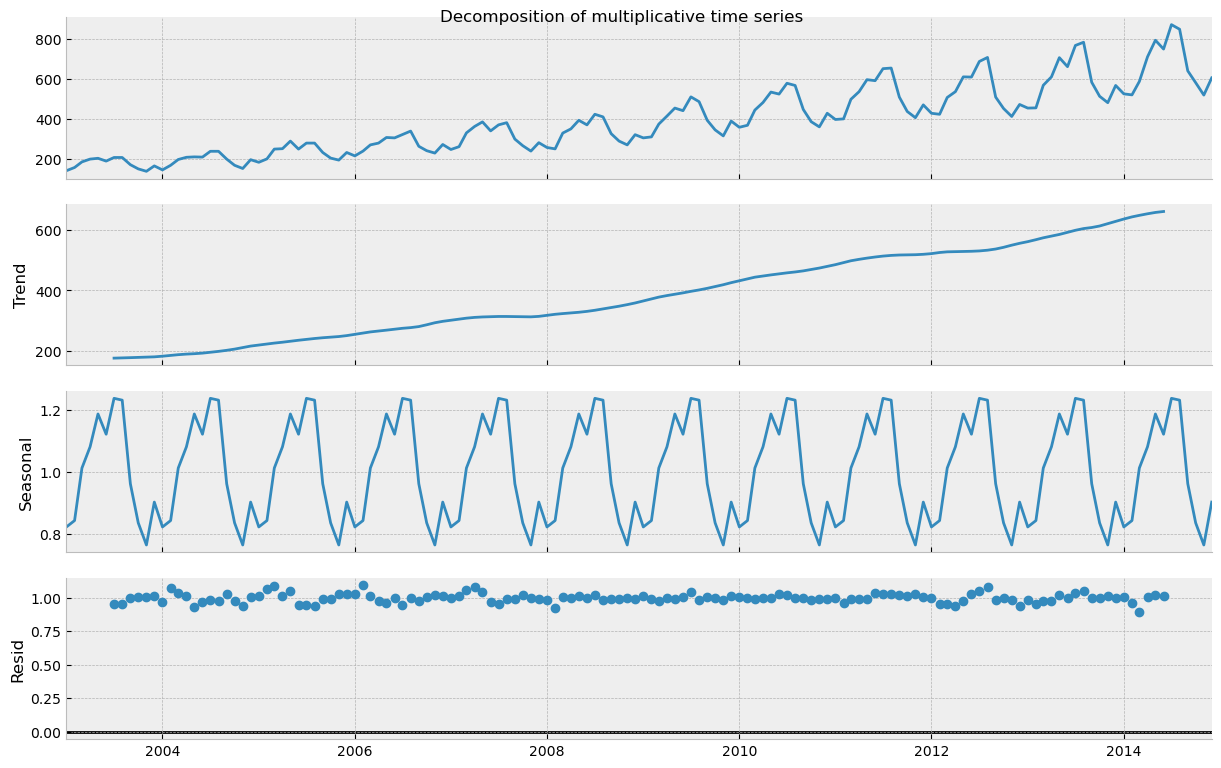

In [23]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

In [ ]:
plot_acf(train,lags=60)
plt.show()

# Train Test Split

In [25]:

train = sales_data[:132]
test = sales_data[132:]

In [ ]:
train.head()

In [ ]:
train.tail()

In [ ]:
test

# Data Transformation

## Making Variance Stationary

In [28]:
def apply_boxcox(series, plot=True):

    # Apply Box-Cox transformation
    transformed_data, lambda_value = boxcox(series)

    # Convert to pandas Series
    transformed_series = pd.Series(transformed_data, index=series.index)

  
    return transformed_series, lambda_value

In [29]:
# Function to perform inverse Box-Cox transformation
def inverse_boxcox(y, lam):
    return np.power(y * lam + 1, 1 / lam) if lam != 0 else np.exp(y)

In [30]:
# Apply Box-Cox transformation
train_boxcox, lambda_value = apply_boxcox(train['Tractor-Sales'])

# Print the optimal lambda value
print(f"Optimal λ (lambda): {lambda_value:.4f}")

Optimal λ (lambda): 0.1198


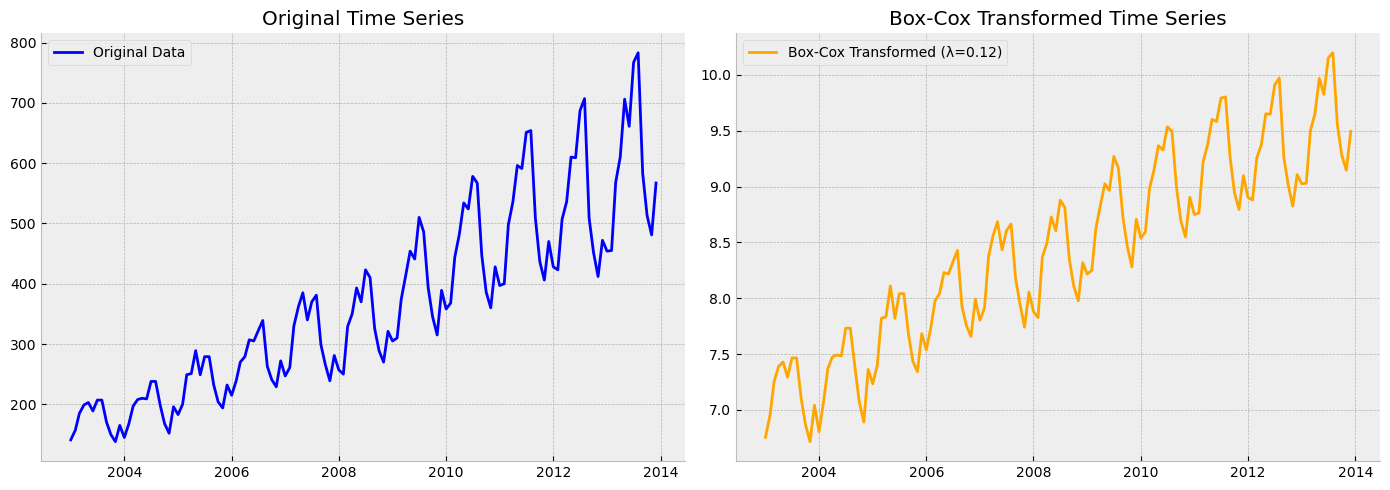

In [31]:
# plot before and after series
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original series
axes[0].plot(train['Tractor-Sales'], label='Original Data', color='blue')
axes[0].set_title('Original Time Series')
axes[0].legend()

# Box-Cox transformed series
axes[1].plot(train_boxcox, label=f'Box-Cox Transformed (λ={lambda_value:.2f})', color='orange')
axes[1].set_title('Box-Cox Transformed Time Series')
axes[1].legend()

plt.tight_layout()
plt.show()

## Trend Stationary


In [32]:
ad_fuller_result = adfuller(train_boxcox)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.9908067202706516
p-value: 0.7566025530508342


In [33]:
df_diff = np.diff(train_boxcox, n=1)

In [34]:
ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.9098165995316654
p-value: 0.044218311358604545


In [35]:
df_diff_seasonal_diff = np.diff(df_diff, n=12)

ad_fuller_result = adfuller(df_diff_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -13.546224459962005
p-value: 2.4585815740201445e-25


In [36]:
df_diff2 = np.diff(df_diff, n=1)

ad_fuller_result = adfuller(df_diff2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -7.846189883306199
p-value: 5.7608220022209525e-12


In [ ]:
# def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
#     results = []
    
#     for order in tqdm_notebook(order_list):
#         try: 
#             model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
#         except:
#             continue
            
#         aic = model.aic
#         results.append([order, aic])
        
#     result_df = pd.DataFrame(results)
#     result_df.columns = ['(p,q)', 'AIC']
    
#     #Sort in ascending order, lower AIC is better
#     result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
#     return result_df

In [40]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

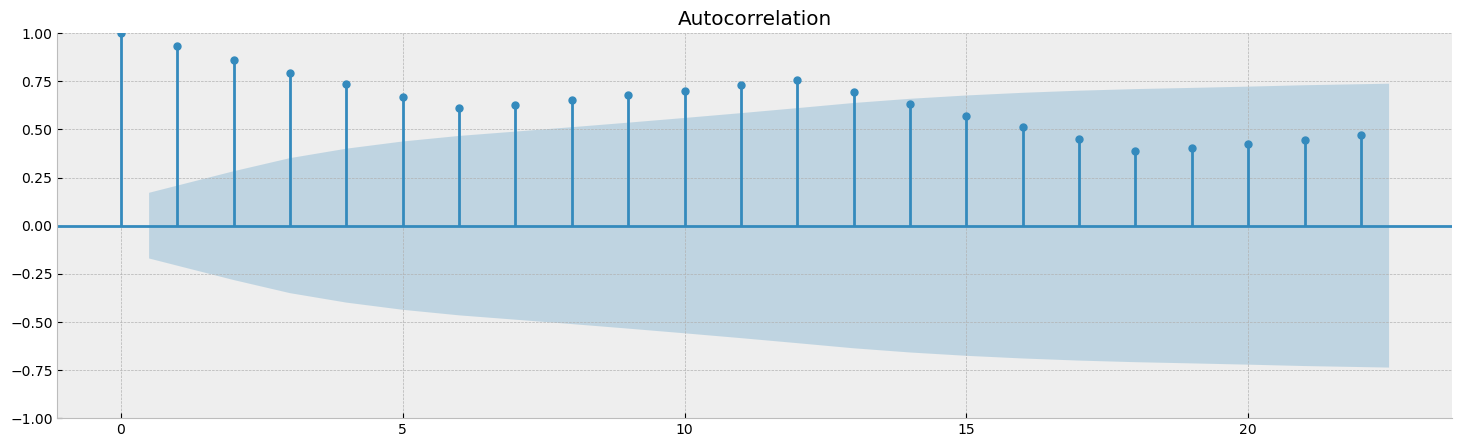

In [37]:
plot_acf(train_boxcox)
plt.show()

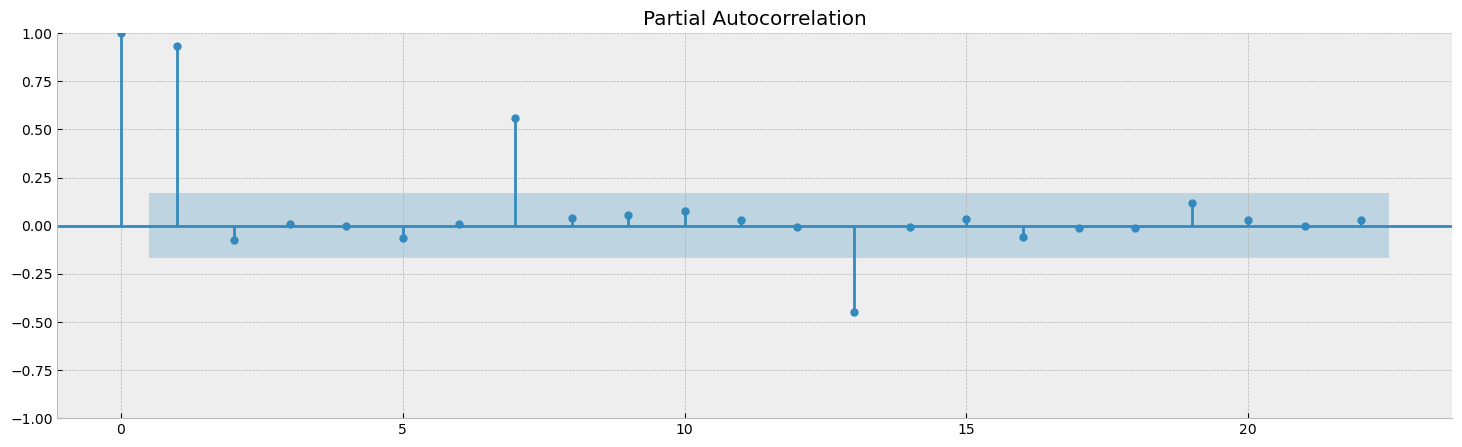

In [38]:
plot_pacf(train_boxcox)
plt.show()

In [41]:
ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps = [0]
Qs = [0]

d = 2
D = 0
s = 12

ARIMA_order_list = list(product(ps, qs, Ps, Qs))


ARIMA_result_df = optimize_SARIMA(train_boxcox, ARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/169 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(11, 12, 0, 0)",-242.977846
1,"(11, 3, 0, 0)",-240.554227
2,"(9, 12, 0, 0)",-239.496584
3,"(11, 4, 0, 0)",-239.084061
4,"(12, 2, 0, 0)",-238.270499
...,...,...
164,"(4, 0, 0, 0)",55.810103
165,"(3, 0, 0, 0)",56.765984
166,"(2, 0, 0, 0)",62.872556
167,"(1, 0, 0, 0)",71.534665


In [42]:
ARIMA_model = SARIMAX(train_boxcox, order=(11,2,12), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

print(ARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  132
Model:             SARIMAX(11, 2, 12)   Log Likelihood                 145.489
Date:                Mon, 03 Mar 2025   AIC                           -242.978
Time:                        17:51:43   BIC                           -174.157
Sample:                    01-01-2003   HQIC                          -215.014
                         - 12-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0167      0.094    -10.779      0.000      -1.202      -0.832
ar.L2         -0.9201      0.090    -10.254      0.000      -1.096      -0.744
ar.L3         -0.9383      0.072    -13.007      0.0

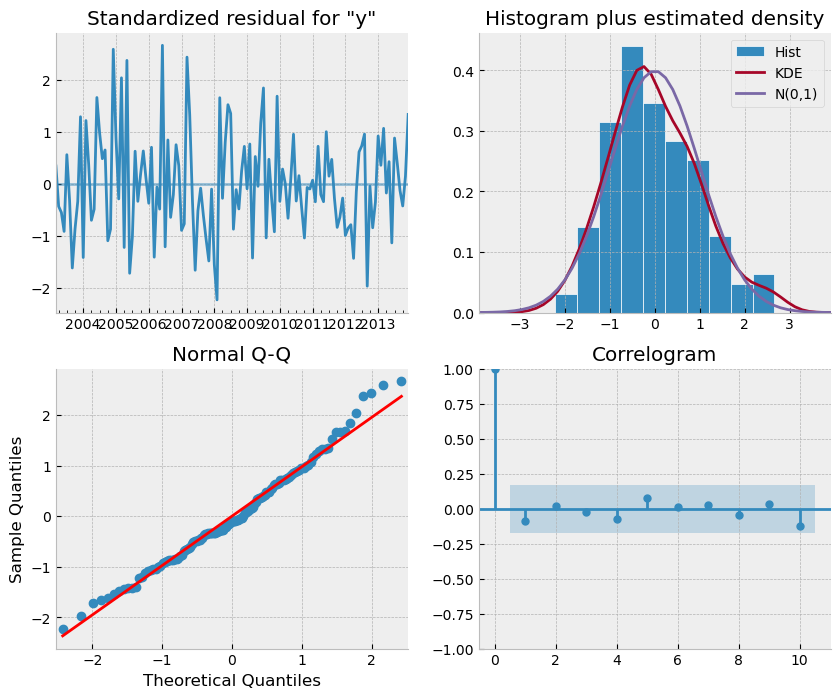

In [44]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));



In [45]:
ARIMA_pred = ARIMA_model_fit.get_prediction(132, 143).predicted_mean

In [46]:
test['ARIMA_pred'] = inverse_boxcox(ARIMA_pred,lambda_value)

In [47]:

test

,Tractor-Sales,ARIMA_pred
2014-01-01,525,540.864261
2014-02-01,520,522.491679
2014-03-01,587,639.797433
2014-04-01,710,694.184213
2014-05-01,793,794.911569
2014-06-01,749,765.473836
2014-07-01,871,867.789077
2014-08-01,848,879.886222
2014-09-01,640,666.496104
2014-10-01,581,597.748138


In [48]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [50]:
mape_ARIMA = mape(test['Tractor-Sales'], test['ARIMA_pred'])

print(mape_ARIMA)

3.3044793002267805


# Sarima Modelling

In [51]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))



d = 1
D = 1
s = 12

SARIMA_result_df = optimize_SARIMA(train_boxcox, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(0, 1, 1, 2)",-274.952933
1,"(2, 1, 0, 1)",-274.947065
2,"(0, 3, 0, 1)",-274.347592
3,"(1, 0, 0, 1)",-274.258071
4,"(0, 1, 0, 1)",-274.220003
...,...,...
251,"(1, 1, 0, 0)",-246.415627
252,"(2, 0, 0, 0)",-246.062963
253,"(0, 2, 0, 0)",-245.748460
254,"(1, 2, 0, 0)",-245.299075


In [52]:
SARIMA_model = SARIMAX(train_boxcox, order=(0,1,1), seasonal_order=(1,1,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  132
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                 142.476
Date:                                 Mon, 03 Mar 2025   AIC                           -274.953
Time:                                         18:09:36   BIC                           -261.057
Sample:                                     01-01-2003   HQIC                          -269.310
                                          - 12-01-2013                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3639      0.082     -4.464      0.000      -0.524      -0

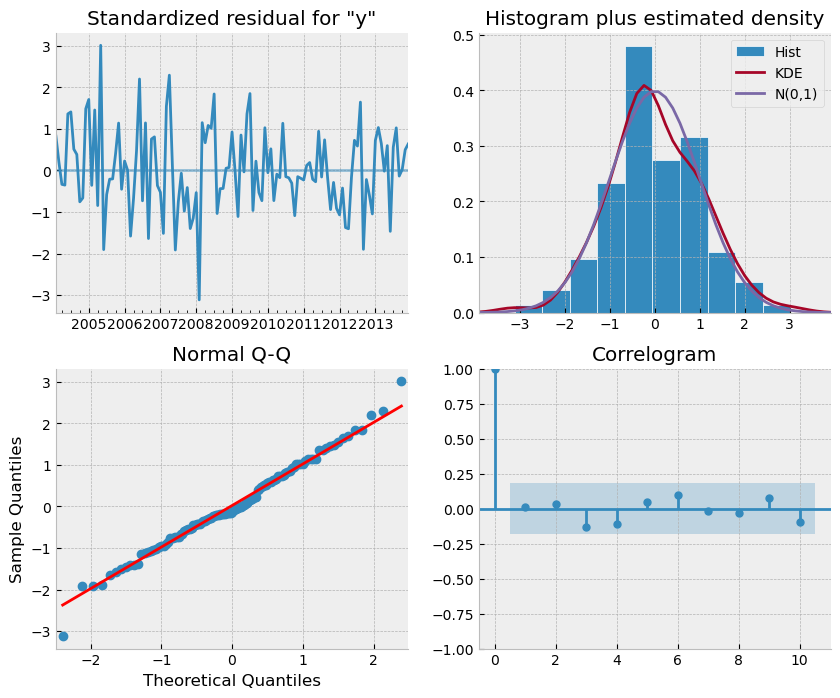

In [53]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));



In [55]:
SARIMA_pred = SARIMA_model_fit.get_prediction(132, 143).predicted_mean

#inverse
test['SARIMA_pred'] = inverse_boxcox(SARIMA_pred,lambda_value)


test.head()

,Tractor-Sales,ARIMA_pred,SARIMA_pred
2014-01-01,525,540.864261,529.067729
2014-02-01,520,522.491679,514.746230
2014-03-01,587,639.797433,639.522648
2014-04-01,710,694.184213,692.136478
2014-05-01,793,794.911569,795.087108


In [58]:
mape_SARIMA = mape(test['Tractor-Sales'], test['SARIMA_pred'])

print(mape_SARIMA)

2.727982443463321


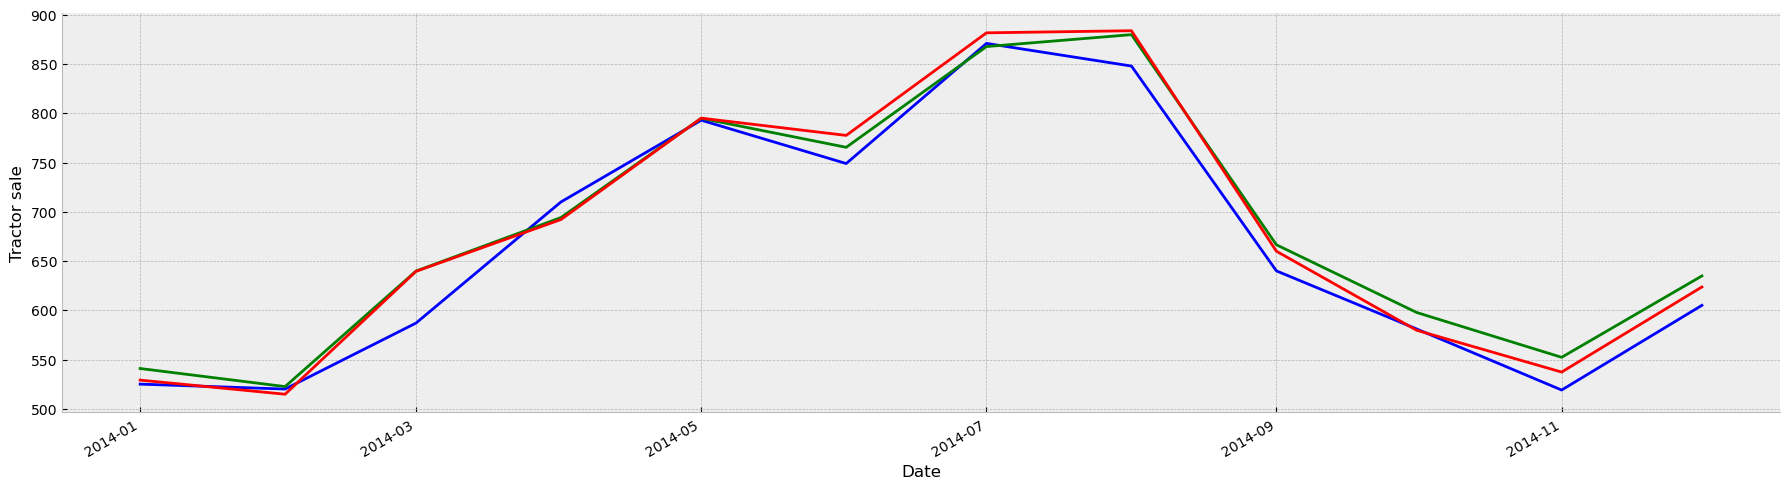

In [81]:
fig, ax = plt.subplots()

# ax.plot(df['Tractor-Sales'])
ax.plot(test['Tractor-Sales'], 'b-', label='actual')
ax.plot(test['ARIMA_pred'], color='green', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], color='red', label='SARIMA(2,1,1)(1,1,2,12)')

ax.set_xlabel('Date')
ax.set_ylabel('Tractor sale')
# ax.axvspan(132, 143, color='#808080', alpha=0.2)


fig.autofmt_xdate()
plt.tight_layout()